# Minimum variance portfolio on selected Danish stocks

In [1]:
from os import listdir
from os.path import isfile, join

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
import scipy.optimize as sco

In [2]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('cubehelix')
plt.rcParams['figure.figsize'] = [5.5, 3]
plt.rcParams['figure.dpi'] = 200

## Load the data

In [3]:
files_name = [f for f in listdir('..\data\DK') if isfile(join('..\data\DK', f))]
stocks_names = [f.split(',')[0].split('_')[2] for f in files_name] 
danish_stocks_df = [pd.read_csv('..\data\DK\\'+f, sep=',', index_col=0, parse_dates=['time']) for f in files_name]
danish_2y_yield = 0.03463

## Preprocessing

### Reindex the dataframe

We need to reindex the various dataframes since in order to calculate the correlations the all the series have to have the same length.

In [4]:
min_index = min(range(len(danish_stocks_df)), key=lambda i: len(danish_stocks_df[i]))
max_index = max(range(len(danish_stocks_df)), key=lambda i: len(danish_stocks_df[i]))

In [5]:
start_date = danish_stocks_df[min_index].index[0]
end_date = danish_stocks_df[max_index].index[-1]
start_date, end_date

(Timestamp('2016-06-09 09:00:00+0200', tz='UTC+02:00'),
 Timestamp('2023-07-07 09:00:00+0200', tz='UTC+02:00'))

In [6]:
def reindex_stocks(dfs: list, start_date: str, end_date: str):
    return [dfs[i].loc[start_date:, :].reindex(pd.date_range(start=start_date, end=end_date, freq='B')).fillna(method='ffill') for i in range(len(dfs))]

In [7]:
danish_stocks_df = reindex_stocks(danish_stocks_df, start_date, end_date)

In [8]:
close_dfs = [df['close'].values for df in danish_stocks_df]

In [9]:
close_df = pd.DataFrame({stock: values for stock, values in zip(stocks_names, close_dfs)}, index=danish_stocks_df[0].index)
close_df.head()

,AOJ,CHR,DNORD,MAERSK,NOVO,NZYM,ORSTED,SKAKO,SOLAR,STG,TRMD,VWS,ZEAL
2016-06-09 09:00:00+02:00,21.20,417.10001,98.500000,8675.0,374.70001,310.10001,258.00000,58.5,334.5,109.0,71.5,92.820002,123.5
2016-06-10 09:00:00+02:00,21.35,408.00000,94.599998,8430.0,364.50000,303.00000,252.00000,57.0,326.0,108.4,65.5,89.820002,121.0
2016-06-13 09:00:00+02:00,21.34,401.70001,91.400002,8255.0,363.20001,302.60001,244.00000,55.0,316.0,106.0,66.5,88.000000,115.5
2016-06-14 09:00:00+02:00,21.34,394.70001,89.750000,7875.0,343.00000,296.89999,249.39999,53.5,310.0,105.0,64.5,85.940002,108.5
2016-06-15 09:00:00+02:00,21.34,397.00000,91.500000,8040.0,344.20001,302.10001,253.50000,57.0,312.5,105.2,65.0,86.479998,113.0


## EDA

In [10]:
returns_df = close_df.pct_change().dropna()
returns_df

,AOJ,CHR,DNORD,MAERSK,NOVO,NZYM,ORSTED,SKAKO,SOLAR,STG,TRMD,VWS,ZEAL
2016-06-10 09:00:00+02:00,0.007075,-0.021817,-0.039594,-0.028242,-0.027222,-0.022896,-0.023256,-0.025641,-0.025411,-0.005505,-0.083916,-0.032321,-0.020243
2016-06-13 09:00:00+02:00,-0.000468,-0.015441,-0.033827,-0.020759,-0.003567,-0.001320,-0.031746,-0.035088,-0.030675,-0.022140,0.015267,-0.020263,-0.045455
2016-06-14 09:00:00+02:00,0.000000,-0.017426,-0.018053,-0.046033,-0.055617,-0.018837,0.022131,-0.027273,-0.018987,-0.009434,-0.030075,-0.023409,-0.060606
2016-06-15 09:00:00+02:00,0.000000,0.005827,0.019499,0.020952,0.003499,0.017514,0.016439,0.065421,0.008065,0.001905,0.007752,0.006283,0.041475
2016-06-16 09:00:00+02:00,0.000000,0.015617,-0.026776,-0.027363,-0.016851,-0.020192,-0.010651,-0.035088,-0.035200,-0.013308,-0.007692,-0.022895,-0.048673
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-03 09:00:00+02:00,0.007916,0.003167,0.035253,0.035491,-0.015281,0.000315,0.000000,-0.006803,0.003960,0.018502,0.021315,-0.000882,-0.002453
2023-07-04 09:00:00+02:00,0.002618,0.010945,0.005675,0.024194,-0.002586,0.010063,-0.003412,0.000000,0.001972,0.013841,0.007752,0.010149,0.007377
2023-07-05 09:00:00+02:00,-0.005222,0.001041,-0.014108,-0.015748,0.015003,-0.000623,-0.024899,-0.020548,-0.011811,-0.008532,-0.009468,-0.026646,0.039870
2023-07-06 09:00:00+02:00,-0.010499,-0.003536,0.008014,-0.012800,-0.012591,-0.004050,-0.019470,0.013986,-0.014940,-0.003442,-0.010155,-0.012790,-0.020344


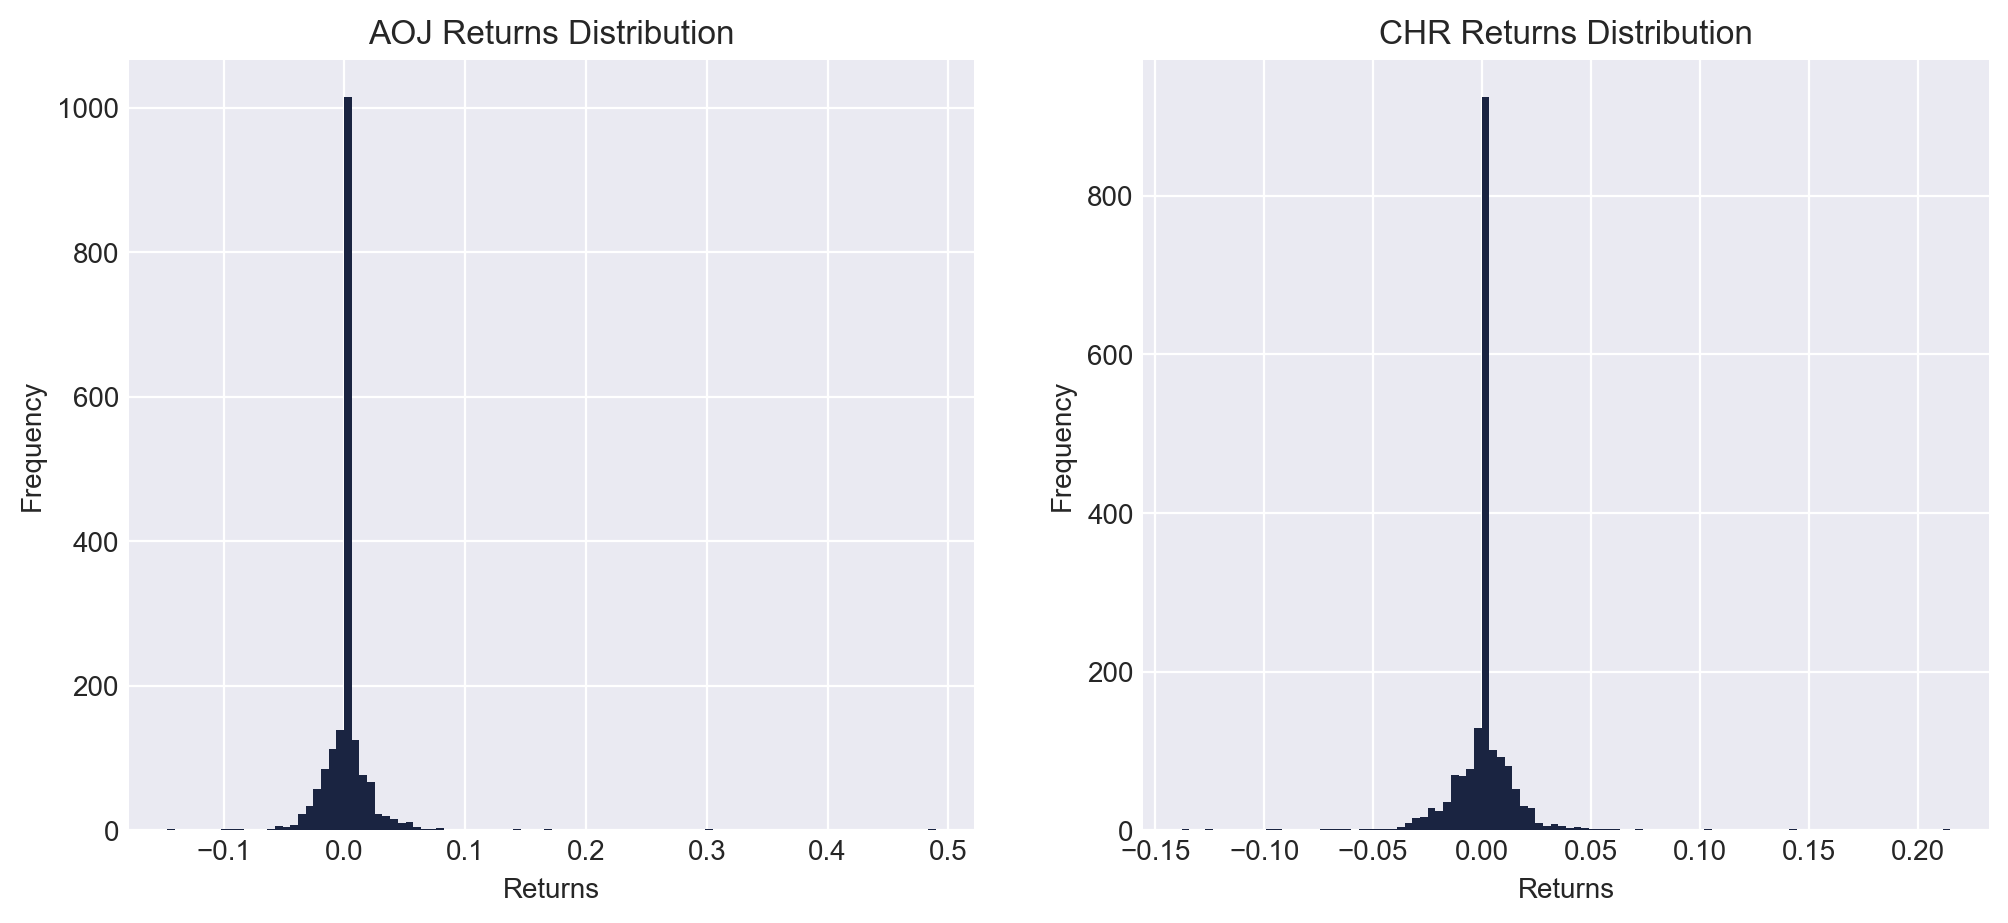

In [11]:
# Visuallize the returns distrubution of AOJ
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(returns_df.loc[:, 'AOJ'], bins=100)
axs[0].set(xlabel='Returns', ylabel='Frequency', title='AOJ Returns Distribution')

axs[1].hist(returns_df.loc[:, 'CHR'], bins=100)
axs[1].set(xlabel='Returns', ylabel='Frequency', title='CHR Returns Distribution')

plt.show()

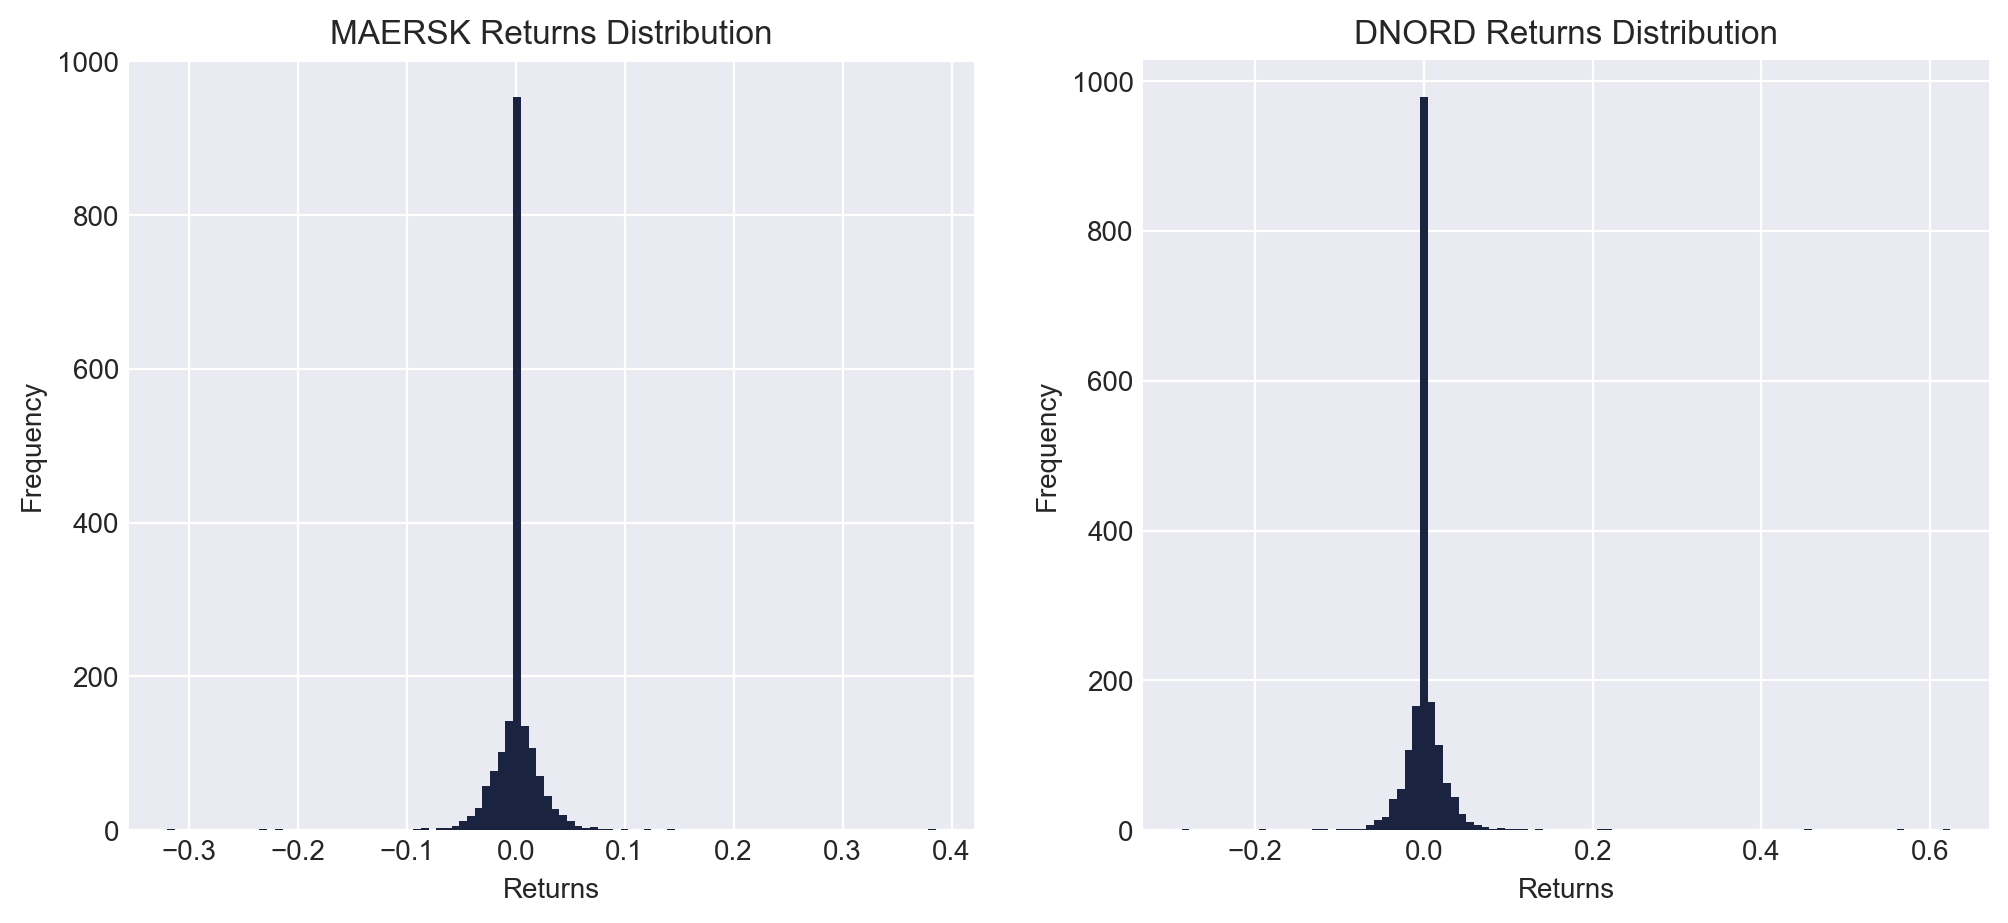

In [12]:
# Visuallize the returns distrubution of AOJ
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].hist(returns_df.loc[:, 'MAERSK'], bins=100)
axs[0].set(xlabel='Returns', ylabel='Frequency', title='MAERSK Returns Distribution')

axs[1].hist(returns_df.loc[:, 'DNORD'], bins=100)
axs[1].set(xlabel='Returns', ylabel='Frequency', title='DNORD Returns Distribution')

plt.show()

### Correlation of the returns

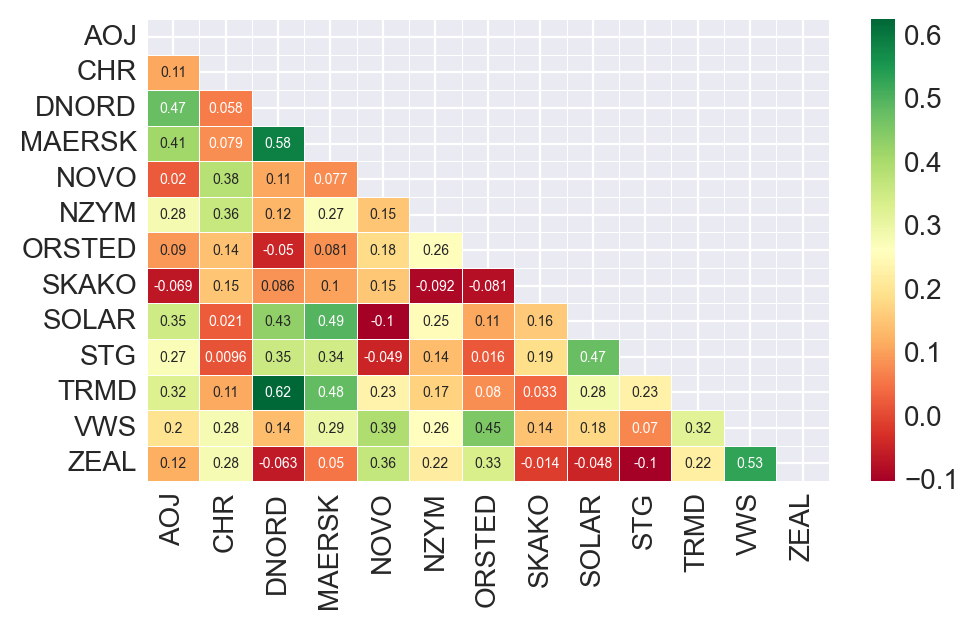

In [13]:
r_corr_matrix = returns_df.corr()

mask = np.zeros_like(r_corr_matrix)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(r_corr_matrix, annot=True, mask=mask, cmap='RdYlGn', linewidths=0.2, annot_kws={'size': 5});

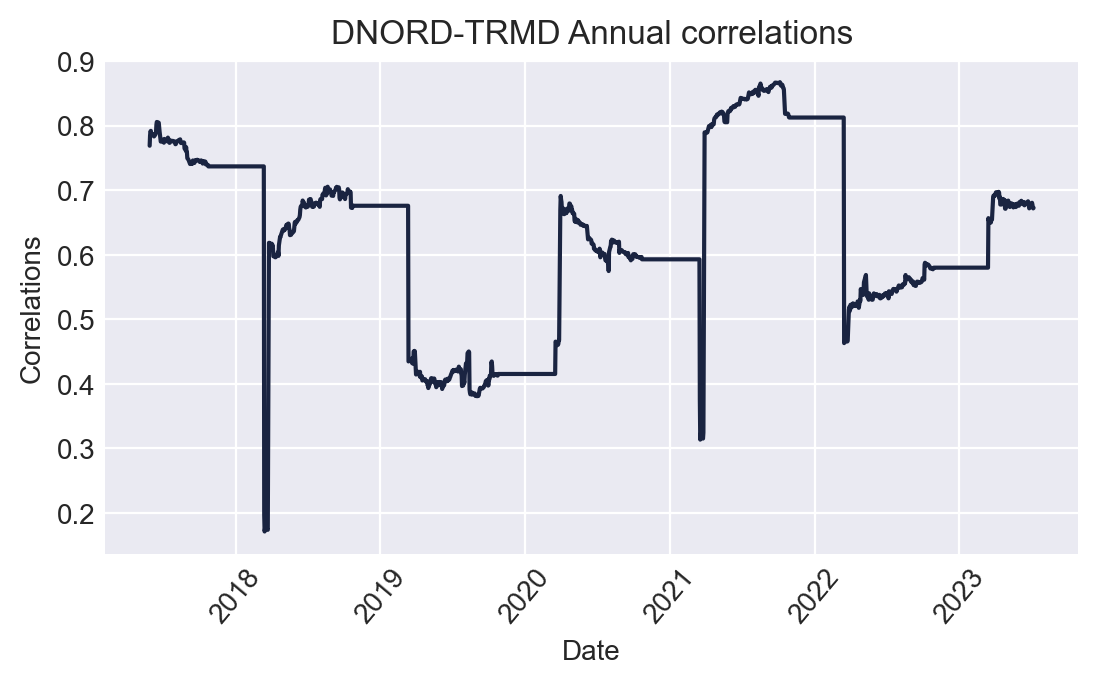

In [14]:
fig, axs = plt.subplots(1, 1, )
fig.tight_layout(h_pad=6)

axs.plot(returns_df['DNORD'].rolling(252).corr(returns_df['TRMD']).dropna())
axs.set_title('DNORD-TRMD Annual correlations')
axs.set_xlabel('Date')
axs.set_ylabel('Correlations')
axs.tick_params(axis="x", rotation=50)

plt.show()

## Portfolio optimization

In [15]:
n_days = 260
n_portfolios = 100000
n_assets = len(stocks_names)
avg_returns = returns_df.mean() * n_days
cov_matrix = returns_df.cov() * n_days

In [16]:
np.random.seed(0)
weights = np.random.random(size=(n_portfolios, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

In [47]:
portf_rtns = np.dot(weights, avg_returns)

portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T, 
                                    np.dot(cov_matrix, weights[i]))))
portf_vol = np.array(portf_vol)  
portf_sharpe_ratio = (portf_rtns - danish_2y_yield) / portf_vol

In [48]:
portf_results_df = pd.DataFrame({'returns': portf_rtns,
                                 'volatility': portf_vol,
                                 'sharpe_ratio': portf_sharpe_ratio})

In [49]:
n_points = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), 
                            portf_results_df.returns.max(), 
                           n_points)
portf_rtns_ef = np.round(portf_rtns_ef, 2)    
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(n_points):
    if portf_rtns_ef[point_index] not in portf_rtns:
        indices_to_skip.append(point_index)
        continue
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))
    
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

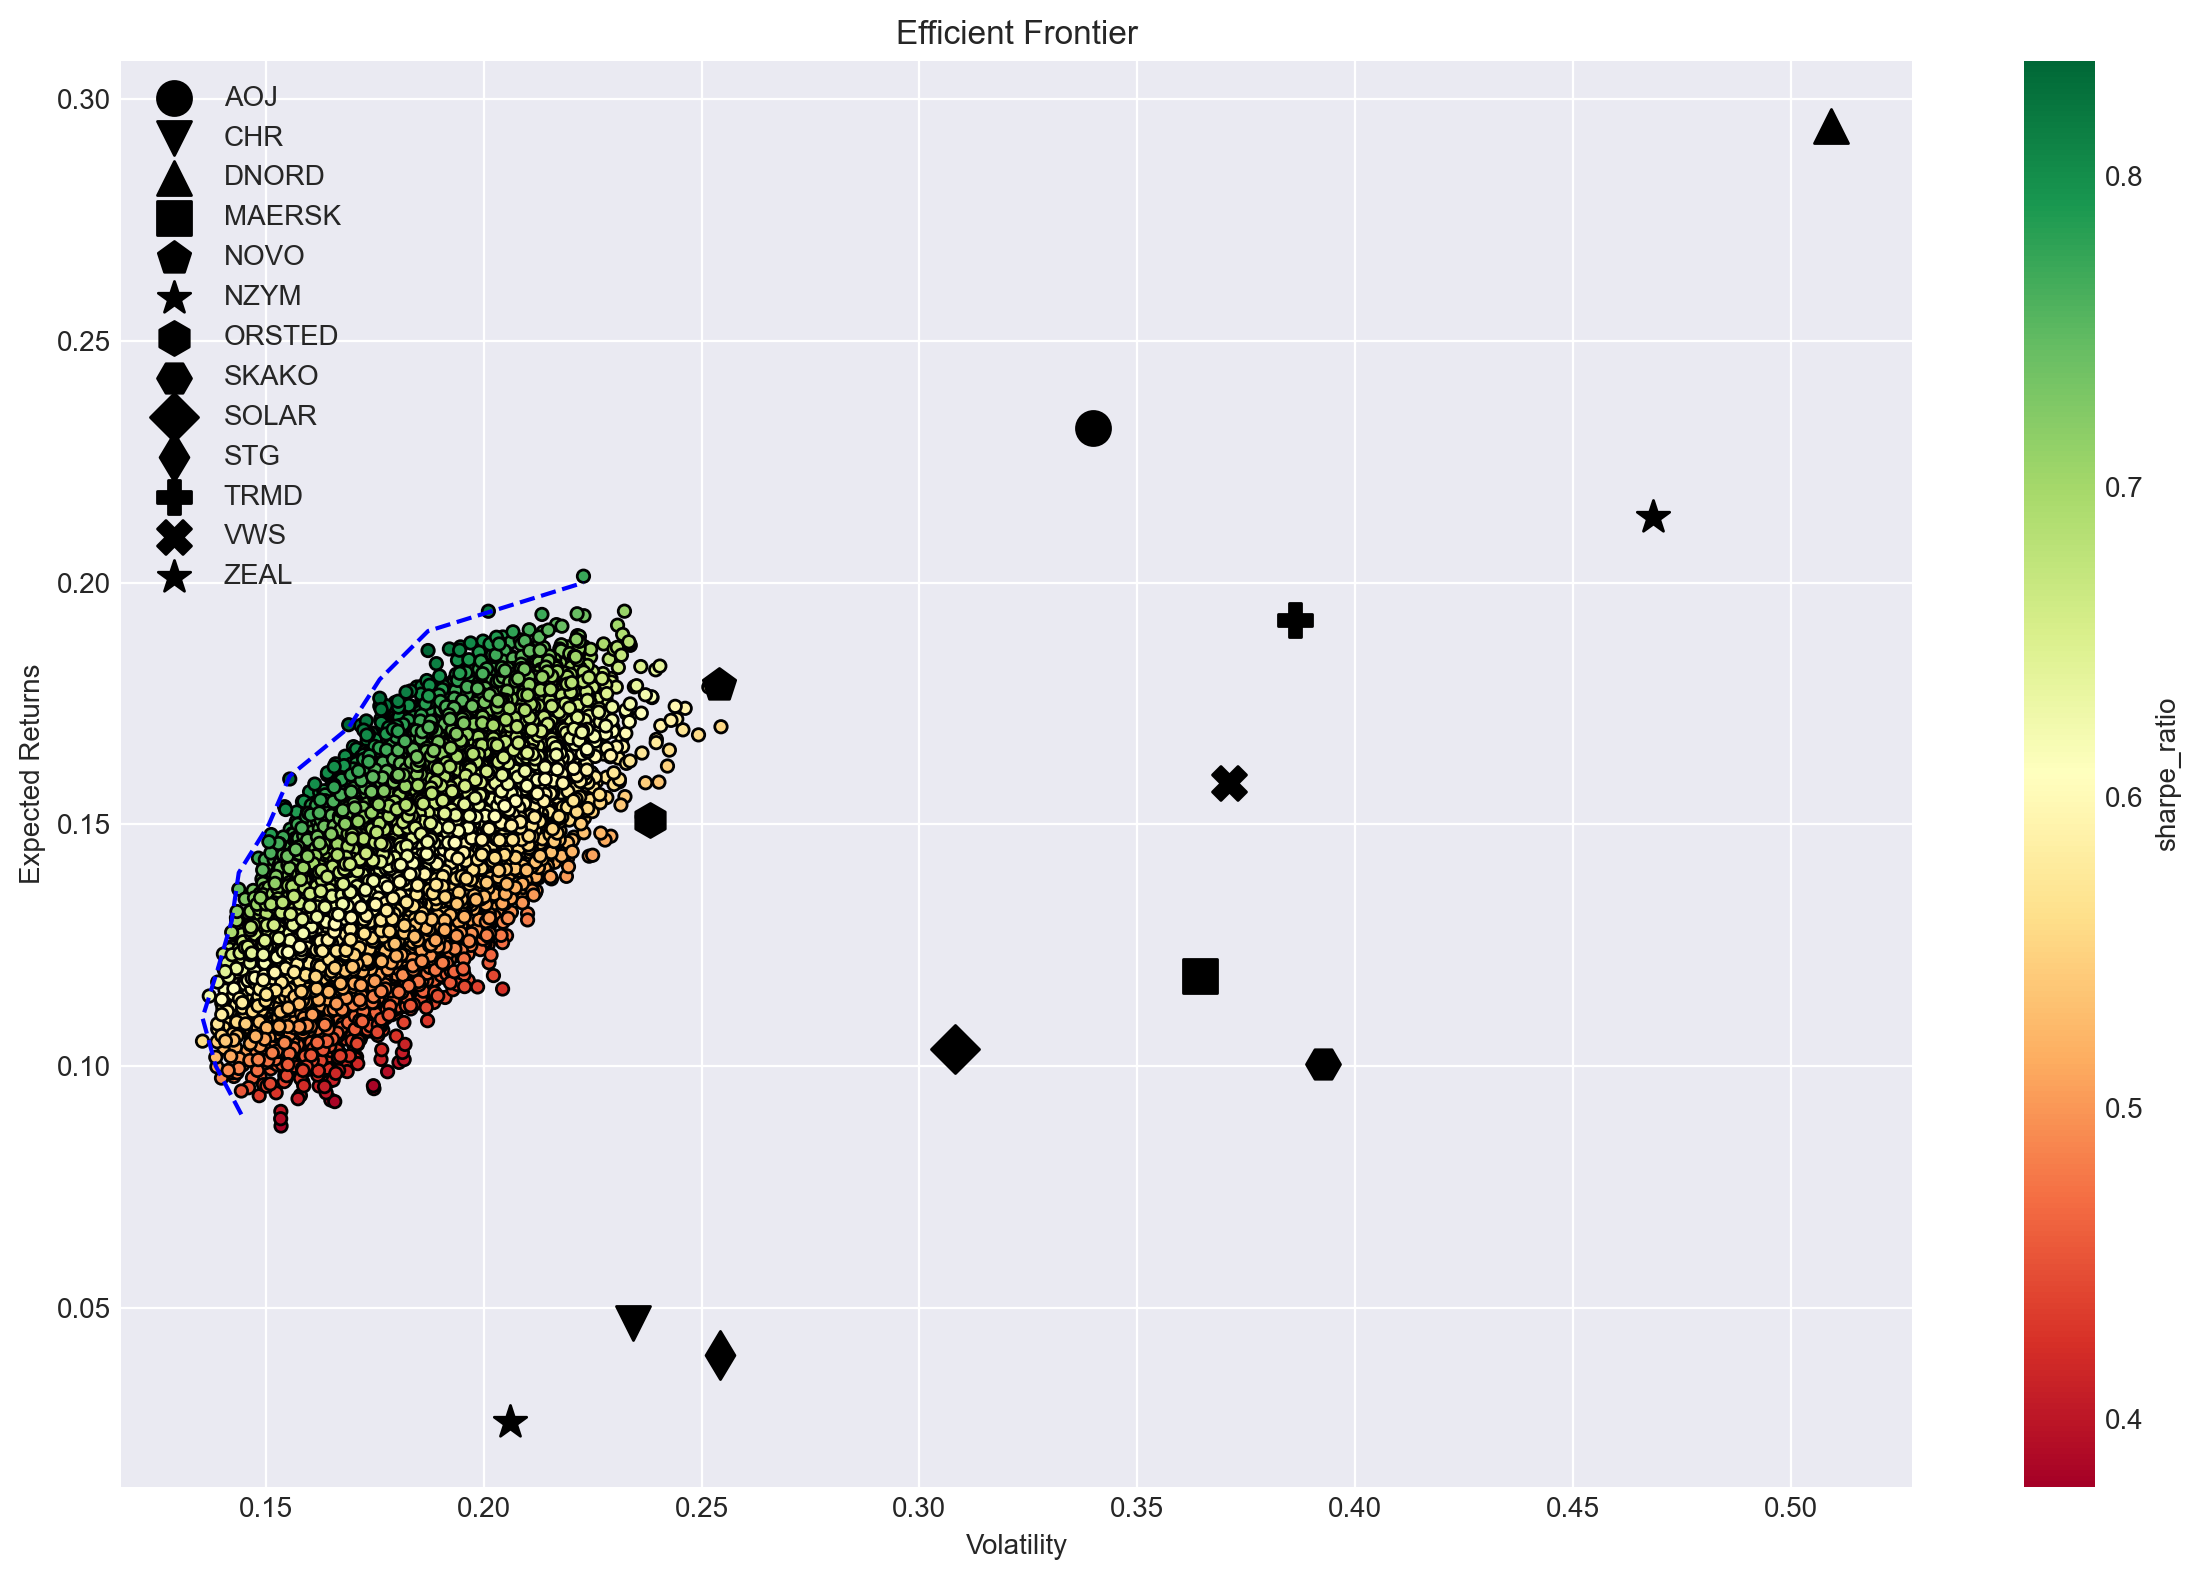

In [50]:
MARKS = ['o', 'v', '^', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X', '*']

fig, ax = plt.subplots(figsize=(12, 8))
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_matrix.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='black',
                label=stocks_names[asset_index])
ax.legend()

plt.tight_layout()
plt.show()

### Min variance portfolio

The term “Minimum Variance Portfolio” refers to the portfolio with the lowest variance. This portfolio can be obtained by solving the following quadratic programming model:

$$
\begin{align}
\min_{w} & \boldsymbol w^T C \boldsymbol w  &\\
\text{s.t.: } & \boldsymbol w^t \boldsymbol \mu &= r^* \\
& \sum_{i=1}^N w_i &= 1
\end{align}
$$

In [52]:
def get_portf_rtn(w, avg_rtns):
    return np.sum(avg_rtns * w)

def get_portf_vol(w, avg_rtns, cov_mat):
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

In [53]:
def get_optimal_portfolio(f_obj, constraints, args, bounds):
    initial_guess = n_assets * [1. / n_assets, ]
    return sco.minimize(f_obj, 
                        x0=initial_guess,
                        args=args,
                        method='SLSQP',
                        bounds=bounds,
                        constraints=constraints)

In [54]:
def get_efficient_frontier(avg_rtns, cov_mat, rtns_range):
    
    efficient_portfolios = []
    
    n_assets = len(avg_returns)
    args = (avg_returns, cov_mat)
    bounds = tuple((0,1) for asset in range(n_assets))
    
    for ret in rtns_range:
        constraints = ({'type': 'eq', 
                        'fun': lambda x: get_portf_rtn(x, avg_rtns) - ret},
                       {'type': 'eq', 
                        'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = get_optimal_portfolio(f_obj=get_portf_vol, 
                                           args=args,
                                           constraints=constraints,
                                           bounds=bounds)
        efficient_portfolios.append(efficient_portfolio)
    
    return efficient_portfolios

In [55]:
rtns_range = np.linspace(-0.22, 0.50, 200)

In [56]:
efficient_portfolios = get_efficient_frontier(avg_returns, 
                                              cov_matrix, 
                                              rtns_range)

In [57]:
vols_range = [x['fun'] for x in efficient_portfolios]

In [58]:
min_vol_ind = np.argmin(vols_range)
min_vol_portf_rtn = rtns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]['fun']

min_vol_portf = {'Return': min_vol_portf_rtn,
                 'Volatility': min_vol_portf_vol,
                 'Sharpe Ratio': ((min_vol_portf_rtn - danish_2y_yield) / 
                                  min_vol_portf_vol)}

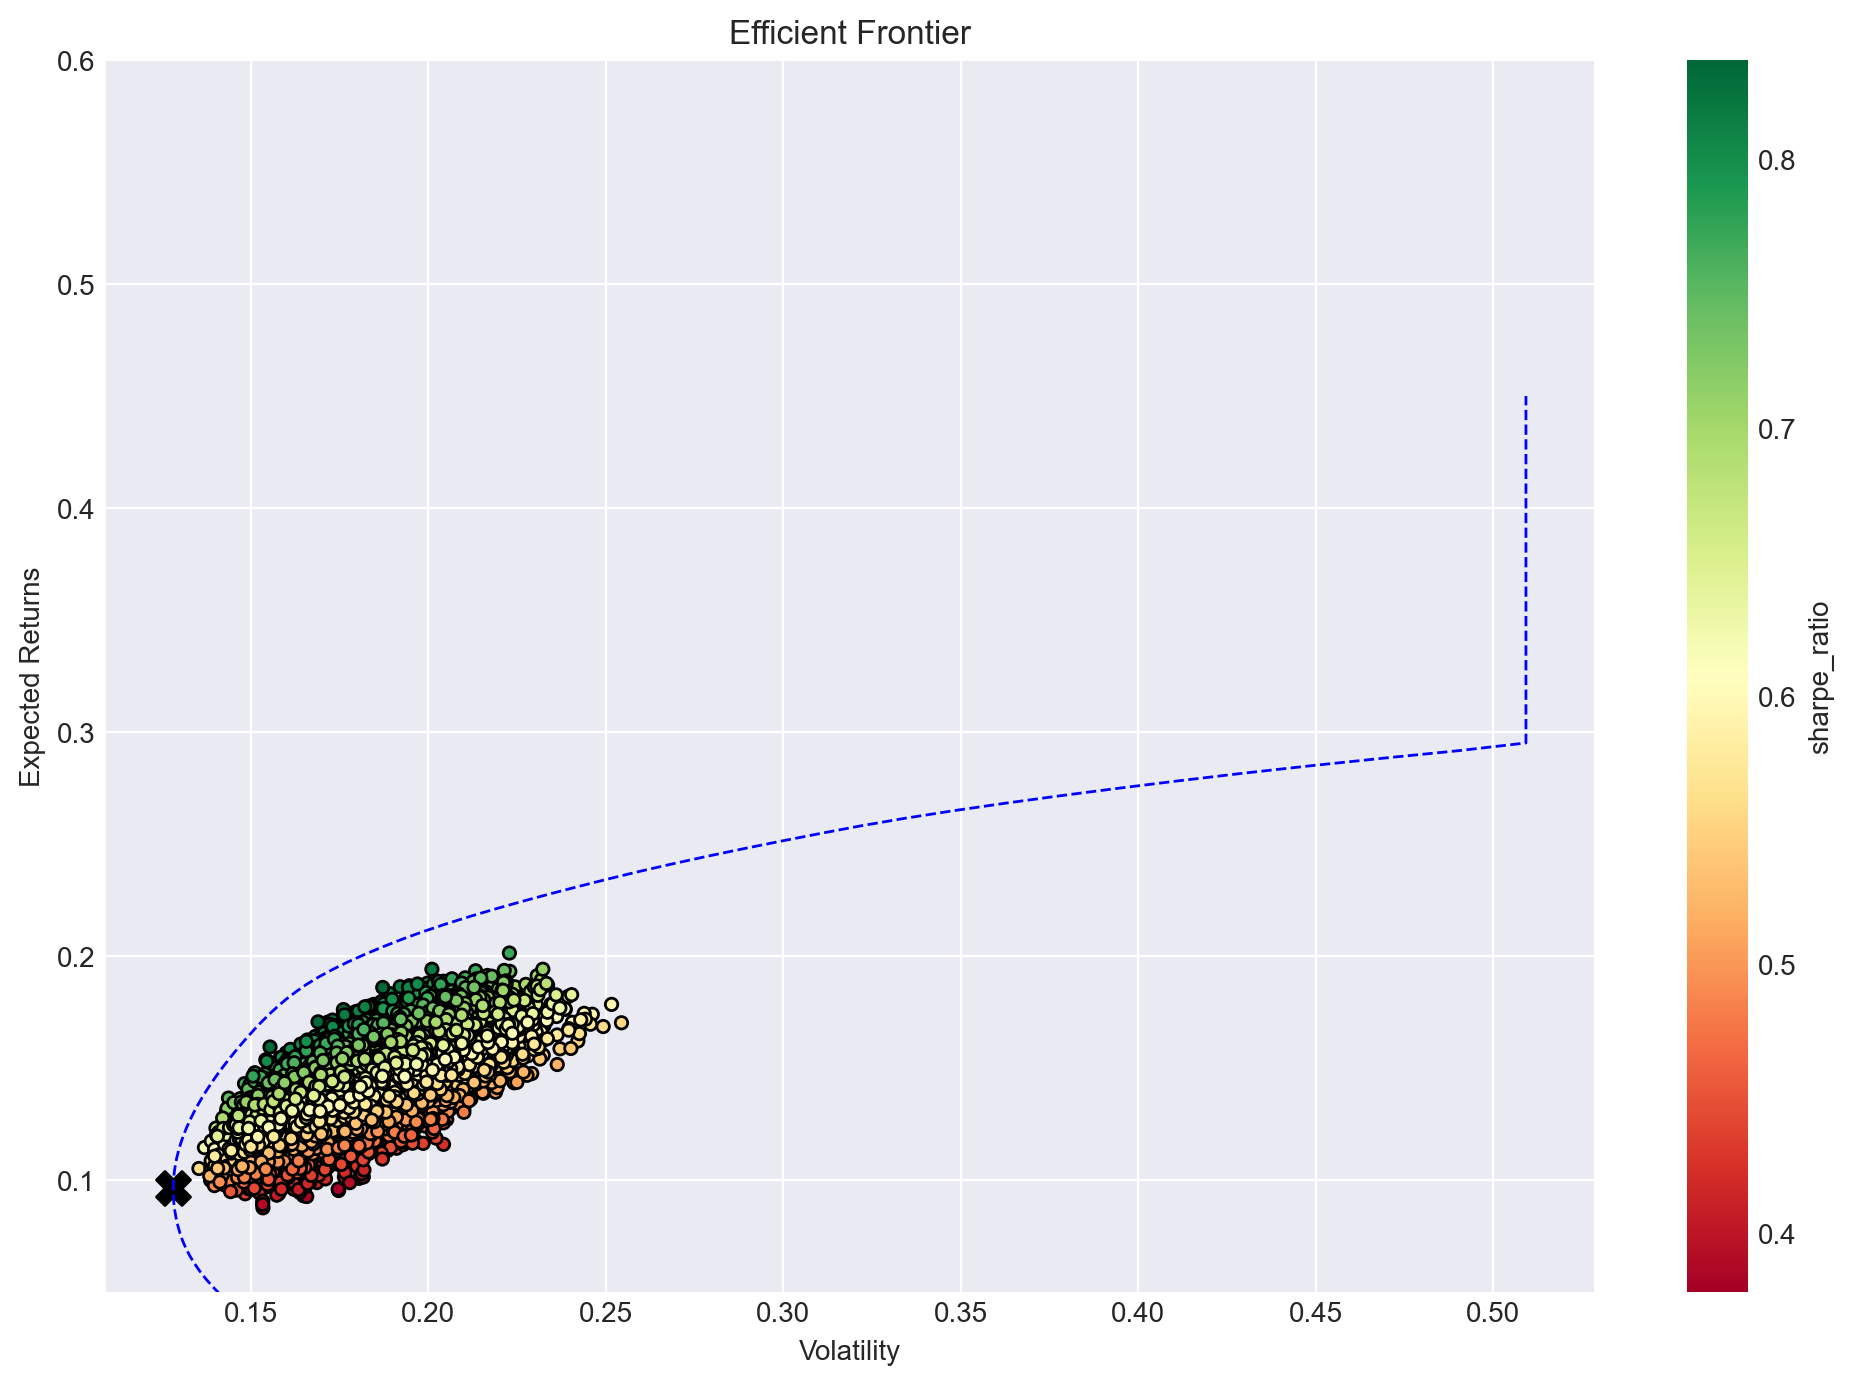

In [59]:
fig, ax = plt.subplots(figsize=(12, 8))
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.plot(vols_range, rtns_range, 'b--', linewidth=1)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.scatter(x=min_vol_portf_vol, 
                y=min_vol_portf_rtn, 
                marker='X', 
                s=150, 
                color='black',
                label='MVP')

plt.ylim(0.05,0.6)
plt.show()

In [60]:
print('Minimum Volatility portfolio ----')
print('Performance')

for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)

print('\nWeights')
for x, y in zip(stocks_names, efficient_portfolios[min_vol_ind]['x']):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
Return: 9.65% Volatility: 12.82% Sharpe Ratio: 52.45% 
Weights
AOJ: 4.56% CHR: 11.53% DNORD: 0.00% MAERSK: 0.00% NOVO: 14.85% NZYM: 20.43% ORSTED: 19.74% SKAKO: 7.91% SOLAR: 2.97% STG: 17.67% TRMD: 0.35% VWS: 0.00% ZEAL: 0.00% 

### Include transaction costs

$$
\begin{align*}
\text{minimize} \quad & \mathbf{w} \mathbf{\Sigma}^T \mathbf{w} \\
\text{subject to} \quad & \mathbf{w}^T \mathbf{\mu} \leq \mathbf{r} \\
& \mathbf{1}^T \mathbf{w}  \leq 1 \\
& \sum_{i} |w_i - w_{0, i}| \cdot c_i \leq T
& \mathbf{x} \geq \mathbf{0}
\end{align*}

$$